In [14]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from torch.distributions import MultivariateNormal

## 1. Prepare the dataset

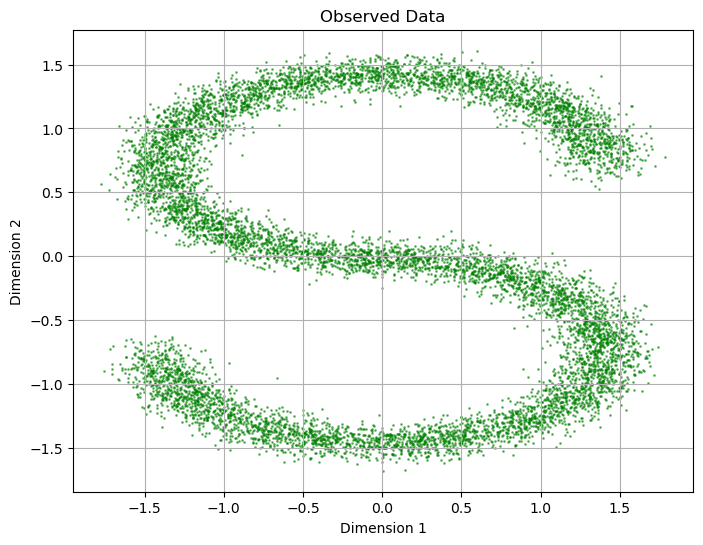

In [15]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate S-curve dataset
data, _ = make_s_curve(n_samples=10000, noise=0.1, random_state=42)

# Use only the first and third dimension
data = data[:, [0, 2]]

# Standardize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Tensorize the data and create a dataloader
dataset = torch.tensor(data, dtype=torch.float32)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=1, c='green')
plt.title('Observed Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

## 2. Construct the Affine Coupling Layer

In [16]:
class AffineCouplingLayer(nn.Module):
    def __init__(self):
        super(AffineCouplingLayer, self).__init__()
        
        self.s_net = nn.Sequential(
            # first layer: 
            nn.Linear(1, 256),
            nn.ReLU(),
            # second layer: 
            nn.Linear(256, 1),
            nn.Tanh()
        )
        
        self.t_net = nn.Sequential(
            # first layer:
            nn.Linear(1, 128),
            nn.ReLU(),
            # second layer: 
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2):
        s = self.s_net(x1)
        t = self.t_net(x1)
        y2 = x2 * torch.exp(s) + t
        y1 = x1
        log_det_jacobian = s.view(s.size(0), -1).sum(dim=1)
        return y1, y2, log_det_jacobian

    def inverse(self, y1, y2):
        s = self.s_net(y1)
        t = self.t_net(y1)
        x2 = (y2 - t) * torch.exp(-s)
        x1 = y1
        log_det_jacobian = -s.view(s.size(0), -1).sum(dim=1)
        return x1, x2, log_det_jacobian

## 3. Construct the RealNVP model

In [17]:
class RealNVP(nn.Module):
    def __init__(self):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList([AffineCouplingLayer() for _ in range(8)])

    def forward(self, x):
        log_det_jacobian = 0
        x1, x2 = x.chunk(2, dim=1)

        for i, layer in enumerate(self.layers):
            if i % 2 == 0:
                y1, y2, ldj = layer(x1, x2)
                x1, x2 = y1, y2
                
            else:
                y2, y1, ldj = layer(x2, x1)
                x1, x2 = y1, y2
                
            log_det_jacobian += ldj

        return torch.cat([y1, y2], dim=1), log_det_jacobian

    def inverse(self, y):
        log_det_jacobian = 0
        y1, y2 = y.chunk(2, dim=1)

        for i, layer in enumerate(reversed(self.layers)):
            if i % 2 == 0:
                x2, x1, ldj = layer.inverse(y2, y1)
                y1, y2 = x1, x2
                
            else:
                x1, x2, ldj = layer.inverse(y1, y2)
                y1, y2 = x1, x2
                
            log_det_jacobian += ldj

        return torch.cat([x1, x2], dim=1), log_det_jacobian

## 4. Train the RealNVP model

In [18]:
def train(model, dataloader, optimizer, num_epochs=500, loss_threshold=1.05):
    
    model.train()
    for epoch in range(num_epochs):
        for batch in dataloader:
            
            # 1. Compute the outputs
            z, log_det_jacobian = model(batch)
            # 2. Compute the cross-entropy loss
            standard_normal = MultivariateNormal(torch.zeros(2), torch.eye(2))
            log_prob = standard_normal.log_prob(z)
            log_likelihood = log_prob + log_det_jacobian
            loss = -log_likelihood.mean() 
            # 3. Compute the gradients of the loss function
            loss.backward()
            # 4. Update all parameters
            optimizer.step()
            # 5. Reset the gradients
            optimizer.zero_grad()

        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Loss: {loss.item():.2f}')

        # Check if loss is below the threshold for early stopping
        if loss.item() < loss_threshold:
            print(f'Training stopped at epoch {epoch + 1}, Loss: {loss.item():.2f}')
            break

In [19]:
# Create a RealNVP model
model = RealNVP()

# Define the optimizer with AdamW algorithm
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# Train the model
train(model, dataloader, optimizer, num_epochs=200)

Epoch 10, Loss: 1.91
Epoch 20, Loss: 2.00
Epoch 30, Loss: 1.61
Epoch 40, Loss: 1.89
Epoch 50, Loss: 1.34
Epoch 60, Loss: 1.49
Epoch 70, Loss: 1.53
Epoch 80, Loss: 1.46
Epoch 90, Loss: 1.42
Epoch 100, Loss: 1.52
Training stopped at epoch 105, Loss: 1.04


## 5. Visualize the training result

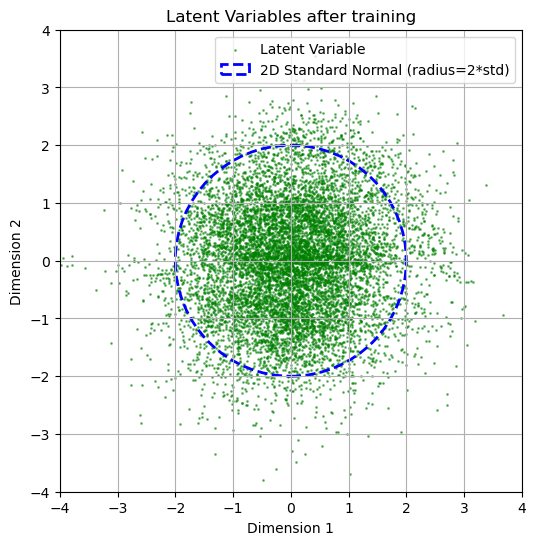

In [27]:
# Visualize the latent space 
z, _ = model(torch.tensor(data, dtype=torch.float32))

plt.figure(figsize=(8, 6))
plt.scatter(z[:, 0].detach().numpy(), z[:, 1].detach().numpy(), 
            s=1, c='green', alpha=0.5, label='Latent Variable')

# Add a circle representing the standard bivariate normal distribution
circle = plt.Circle((0, 0), 2, color='blue', fill=False, linewidth=2, 
                    linestyle='--', label='2D Standard Normal (radius=2*std)')
plt.gca().add_artist(circle)

plt.title('Latent Variables after training')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')

# Add legend
plt.legend()
plt.show()

## 6. Outlier Detection

### 6.1 Methode 1: Using the likelihood of observed data

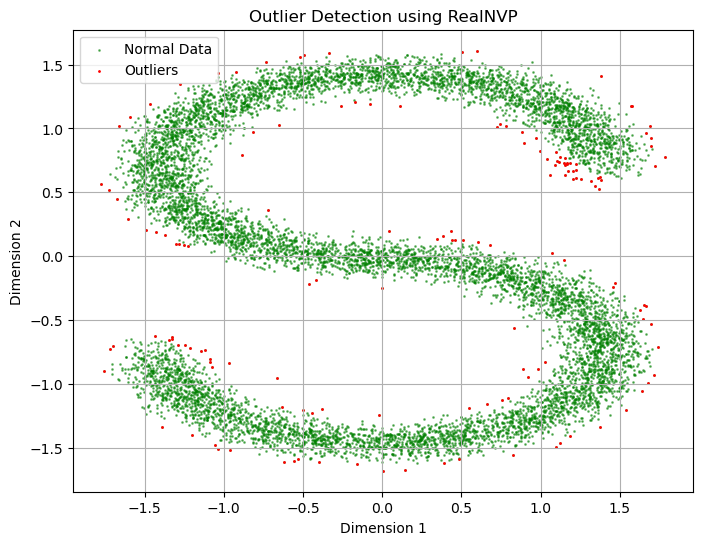

In [21]:
# We want to find outliers from the "S" dataset we generated.
data_tensor = torch.tensor(data, dtype=torch.float32)

# this functions computes the log-likelihood of datapoint x
def compute_log_likelihood(model, x):
    with torch.no_grad():
        z, log_det_jacobian = model.forward(x)
    z = z.numpy()
    log_det_jacobian = log_det_jacobian.numpy()
    
    # z follows 2-dimensional standard normal distribution
    mean = np.zeros(2)
    cov = np.eye(2)
    
    # Calculate the log probability density for z
    log_prob_density_z = multivariate_normal.logpdf(z, mean=mean, cov=cov)
    
    # Compute the log likelihood for x
    log_likelihood_x = log_prob_density_z + log_det_jacobian
    return log_likelihood_x

# Compute log-likelihood for the entire dataset
log_likelihood = compute_log_likelihood(model, data_tensor)

# Set a threshold to indentify outliers:
# 1.5% datapoints with the lowest probability density
threshold = np.percentile(log_likelihood, 1.5)

# Mark the outliers
outliers = log_likelihood < threshold

# Visualize the result
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], 
            alpha=0.5, s=1, c='green', label='Normal Data')
plt.scatter(data[outliers, 0], data[outliers, 1], 
            alpha=1, s=1, c='red', label='Outliers')
plt.title('Outlier Detection using RealNVP')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

### 6.2 Methode 2: Using the probability density of latent variable

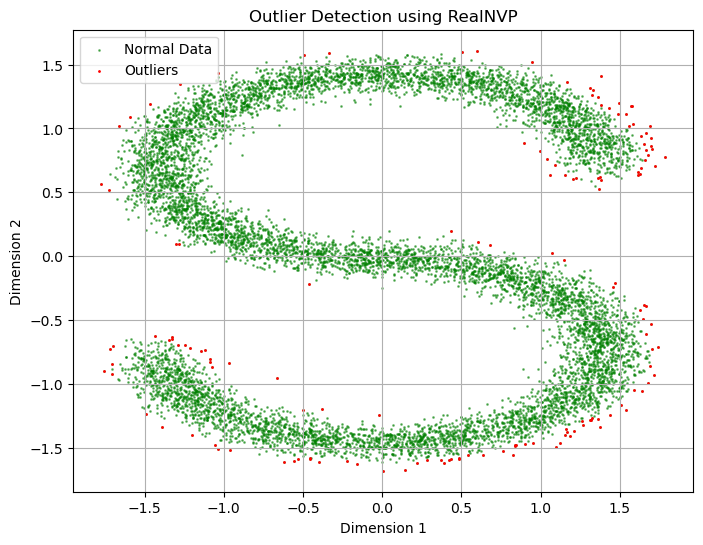

In [22]:
# We want to find outliers from the "S" dataset we generated.

data_tensor = torch.tensor(data, dtype=torch.float32)

# Compute latent variables z
def compute_z(model, dataset):
    with torch.no_grad():
        z, _ = model.forward(dataset)
    return z

z = compute_z(model, data_tensor)
z = z.numpy()

# z follows 2-dimensional standard normal distribution
mean = np.zeros(2)
cov = np.eye(2)
# calculate probability density for each z
prob_density = multivariate_normal.pdf(z, mean=mean, cov=cov)

# Set a threshold to indentify outliers:
# 1.5% datapoints with the lowest probability density
threshold = np.percentile(prob_density, 1.5)

# Mark the outliers
outliers = prob_density < threshold

# Visualize the result
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], 
            alpha=0.5, s=1, c='green', label='Normal Data')
plt.scatter(data[outliers, 0], data[outliers, 1], 
            alpha=1, s=1, c='red', label='Outliers')
plt.title('Outlier Detection using RealNVP')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

## 7. Sampling

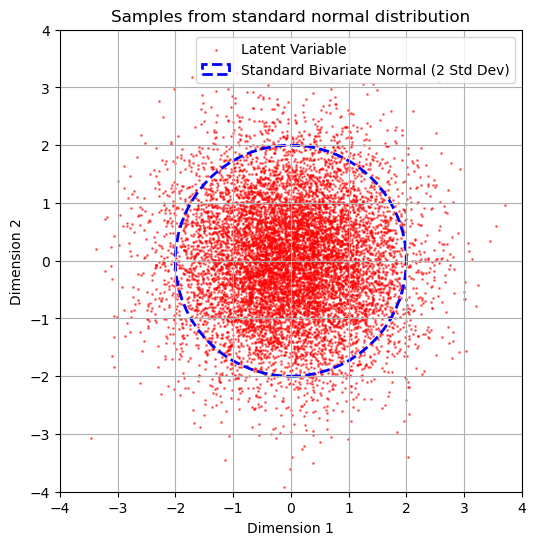

In [23]:
# Generate samples from 2-dimensional standard normal distribution in the latent space
latent_samples = torch.randn(10000, 2)

# Visualize the samples
plt.figure(figsize=(8, 6))
plt.scatter(latent_samples[:, 0].detach().numpy(), latent_samples[:, 1].detach().numpy(), 
            s=1, c='red', alpha=0.5, label='Latent Variable')

# Add a circle representing the standard bivariate normal distribution
circle = plt.Circle((0, 0), 2, color='blue', fill=False, linewidth=2, linestyle='--', 
                    label='Standard Bivariate Normal (2 Std Dev)')
plt.gca().add_artist(circle)

plt.title('Samples from standard normal distribution')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')

# Add legend
plt.legend()
plt.show()

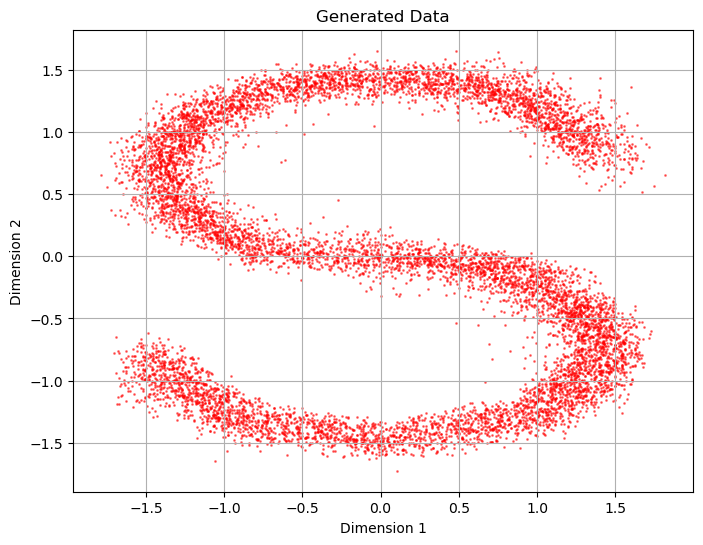

In [24]:
# Generate samples in the original space with inverse transformation
generated_data, _ = model.inverse(latent_samples)

# Visualize the generated samples
plt.figure(figsize=(8, 6))
plt.scatter(generated_data[:, 0].detach().numpy(), 
            generated_data[:, 1].detach().numpy(), 
            s=1, c='red', alpha=0.5)
plt.title('Generated Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()